# Monitoring problem

In [34]:
'''
Set-up:
1) 3 states, 2 actions
2) 2 initial constraints
2) Infeasibile initial constraints
3) Use ResPG-PD, ResOPG-PD

'''

'\nSet-up:\n1) 3 states, 2 actions\n2) 2 initial constraints\n2) Infeasibile initial constraints\n3) Use ResPG-PD, ResOPG-PD\n\n'

In [35]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [36]:
## Random Seed
np.random.seed(10)
## Problem Setup
gamma = 0.9
n, m = 3, 2 # s, a
'''
Probability transition matrix
Each row sums up to one
'''
prob_transition = np.array([[0,1.0,0],[0,0,1.0],[0,1.0,0],[1.0,0,0],[0,0,1.0],[1.0,0,0]])
'''
Rewards: time in S0
'''
reward = np.array([1.0,1.0,0,0,0,0])

'''
Utilities: b1=1,b2=1.2
'''
uval1 = 1.0
uval2 = 1.2
utility1 = np.array([0,0,uval1,uval1,0,0])
utility2 = np.array([0,0,0,0,uval2,uval2])
'''
Start state distribution: uniform
'''
rho = np.array([1/3,1/3,1/3])


'''
2 initial constraints
'''
u_constraint1 = 7
u_constraint2 = 9

## Useful functions

In [37]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)

    return np.asarray(prob)


"""
Input: Discrete probability distributions p, q : array-like, dtype=float, shape=n
Output: Kullback-Leibler divergence D(p||q)
"""
def kl_div(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [38]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]

    return Pi

In [39]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])

    ell = np.dot(V,rho)
    return ell

In [40]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def project_to_policy(theta,n,m):
    prob = []
    prob_pers = []
    for i in range(n):
#         norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        prob_pers = projection_simplex_sort(theta[m*i:m*(i+1)], z=1)
        for j in range(m):
            prob.append(prob_pers[j])

    return np.asarray(prob)

In [41]:
'''
The projection function
Input: a scalar
Output: a scalar in the interval [0 C]
'''
def proj(scalar,gamma):
    offset = 1000/(1-gamma)
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar

In [42]:
"""
License: BSD
Author: Mathieu Blondel
Implements three algorithms for projecting a vector onto the simplex: sort, pivot and bisection.
For details and references, see the following paper:
Large-scale Multiclass Support Vector Machine Training via Euclidean Projection onto the Simplex
Mathieu Blondel, Akinori Fujino, and Naonori Ueda.
ICPR 2014.
http://www.mblondel.org/publications/mblondel-icpr2014.pdf
"""

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)

    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)

        if abs(value) <= tau:
            break

        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint

    return np.maximum(v - midpoint, 0)

In [43]:

'''
The projection function for xi
Input: a scalar
Output: a scalar in the interval [-C C]
'''


def proj_xi1(scalar, gamma):
    max = 0
    min = -2*uval1/(1-gamma)

    if scalar < min:
        scalar = min;
    if scalar > max:
        scalar = max

    return scalar

def proj_xi2(scalar, gamma):
    max = 0
    min = -2*uval2/(1-gamma)

    if scalar < min:
        scalar = min;
    if scalar > max:
        scalar = max

    return scalar



In [44]:
'''
Input: theta as an array
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy_naive(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(theta[m*i:m*(i+1)])
        for j in range(m*i,m*(i+1)):
            prob.append(theta[j]/norm)

    return np.asarray(prob)

## Resilient Policy Gradient Primal-Dual (ResPG-PD) Method

In [45]:
'''
Policy search via ResPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''


def NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2,  stepsize, alpha, total_iterates, init_constraint1, init_constraint2, show_detail = True, optimal_policy = np.array([]) ):

    theta = np.random.uniform(0,1,size=n*m)
    dual1 = 0
    xi1 = 0

    dual2 = 0
    xi2 = 0


    reward_value = []
    utility_value1 = []
    utility_value2 = []
    xi_value1 = []
    xi_value2 = []
    distance = []

    # derivative of relaxation function
    dh1 = lambda x:2*alpha*(x)
    dh2 = lambda x:2*alpha*(x)


    # Transform into V_{g'}>=\xi
    utility1 = utility1 - init_constraint1*(1-gamma)
    utility2 = utility2 - init_constraint2*(1-gamma)

    theta = project_to_policy(theta,n,m)
    for k in range(total_iterates):

        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)
        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2


        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta = project_to_policy(theta + stepsize*qvals,n,m)

        # update xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi1 = xi1 + stepsize*grad_xi1
        xi2 = xi2 + stepsize*grad_xi2
        xi1 = proj_xi1(xi1,gamma)
        xi2 = proj_xi2(xi2,gamma)

        # dual descent
        dual1 = dual1 - stepsize*violation_gradient1
        dual1 = proj(dual1,gamma)
        dual2 = dual2 - stepsize*violation_gradient2
        dual2 = proj(dual2,gamma)

        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta,rho)
              avg_utility1 = ell(qvals_utility1,theta,rho)
              avg_utility2 = ell(qvals_utility2,theta,rho)
              reward_value.append(avg_reward)
              utility_value1.append(avg_utility1)
              utility_value2.append(avg_utility2)
              xi_value1.append(xi1)
              xi_value2.append(xi2)
              if len(optimal_policy) != 0:
                policy = theta_to_policy(theta,n,m)
                policy_norm_squared = np.inner(theta - optimal_policy, theta - optimal_policy)
                distance.append(policy_norm_squared)



    if show_detail == True:
        return reward_value, utility_value1, utility_value2, xi_value1, xi_value2, distance
    else:
        reward_value = ell(qvals_reward,theta,rho)
        avg_utility1 = ell(qvals_utility1,theta,rho)
        avg_utility2 = ell(qvals_utility2,theta,rho)
        return reward_value, avg_utility1, avg_utility2, xi1, xi2


## Resilient Optimistic Policy Gradient Primal-Dual (ResOPG-PD) Method

In [46]:
'''
Policy search via ResOPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''

def Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates, init_constraint1,init_constraint2, show_detail = True, optimal_policy = None ):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual1 = 0
    dual_h1 = 0
    xi1 =0
    xi_h1 = 0

    dual2 = 0
    dual_h2 = 0
    xi2 =0
    xi_h2 = 0


    reward_value = []
    utility_value1 = []
    utility_value2 = []
    xi_value1 = []
    xi_value2 = []
    distance = []

    # Transform into V_{g'}>=\xi
    utility1 = utility1 - init_constraint1*(1-gamma)
    utility2 = utility2 - init_constraint2*(1-gamma)

    # derivative of relaxation function
    dh1 = lambda x:2*alpha*(x)
    dh2 = lambda x:2*alpha*(x)

    theta = project_to_policy(theta,n,m)
    theta_h = project_to_policy(theta_h,n,m)
    for k in range(total_iterates):

        # optimistic step for (theta, dual)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)
        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2

        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta = project_to_policy(theta_h + stepsize*qvals,n,m)

        # update xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi1 = xi_h1 + stepsize*grad_xi1
        xi2 = xi_h2 + stepsize*grad_xi2
        xi1 = proj_xi1(xi1,gamma)
        xi2 = proj_xi2(xi2,gamma)

        # dual descent
        dual1 = dual_h1 - stepsize*violation_gradient1
        dual1 = proj(dual1,gamma)

        dual2 = dual_h2 - stepsize*violation_gradient2
        dual2 = proj(dual2,gamma)


        # optimistic step for (theta_h, dual_h)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)

        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2


        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta_h = project_to_policy(theta_h + stepsize*qvals,n,m)

        # uodate xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi_h1 = xi_h1 + stepsize*grad_xi1
        xi_h2 = xi_h2 + stepsize*grad_xi2

        xi_h1 = proj_xi1(xi_h1,gamma)
        xi_h2 = proj_xi2(xi_h2,gamma)

        # dual descent
        dual_h1 = dual_h1 - stepsize*violation_gradient1
        dual_h1 = proj(dual_h1,gamma)

        dual_h2 = dual_h2 - stepsize*violation_gradient2
        dual_h2 = proj(dual_h2,gamma)

        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta_h,rho)
              avg_utility1 = ell(qvals_utility1,theta_h,rho)
              avg_utility2 = ell(qvals_utility2,theta_h,rho)

              reward_value.append(avg_reward)
              utility_value1.append(avg_utility1)
              utility_value2.append(avg_utility2)

              xi_value1.append(xi_h1)
              xi_value2.append(xi_h2)
              if len(optimal_policy) != 0:

                policy_norm_squared = np.inner(theta_h - optimal_policy, theta_h - optimal_policy)
                distance.append(policy_norm_squared)





    if show_detail == True:
        return reward_value, utility_value1, utility_value2, xi_value1, xi_value2, distance
    else:
        reward_value = ell(qvals_reward,theta_h,rho)
        avg_utility1 = ell(qvals_utility1,theta_h,rho)
        avg_utility2 = ell(qvals_utility2,theta_h,rho)
        return reward_value, avg_utility1, avg_utility2, xi_h1, xi_h2


## Quadratic Programming Solver for optimality

In [47]:
import numpy
import cvxopt
import cvxopt.solvers
from cvxopt import matrix, solvers

alpha_list1 = [0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18]
alpha_list2 = alpha_list1



# x = [theta xi1 xi2]
# minimize 1/2x^T@Q@x + c^T@x
#
# such that
#          A_ub @ x <= b_ub, lb <= x <= ub  ----> [I -I A_ub] @ x <= [ub -lb b_ub]
#          A_eq @ x == b_eq
#
#



optimal_dict = {}

utility11 = utility1 - u_constraint1*(1-gamma)
utility21 = utility2 - u_constraint2*(1-gamma)

for i in range(len(alpha_list1)):

  alpha1 = alpha_list1[i]
  alpha2 = alpha_list2[i]

  cur_dict = {}
  c = -reward
  c = np.append(c,[0,0])
  Q = np.zeros([m*n+2,m*n+2])
  Q[m*n,m*n] = 2*alpha1
  Q[m*n+1,m*n+1] = 2*alpha2

  A_ub0_1 = -np.append(utility11, [-1,0]).reshape(1, n*m+2)
  b_ub0_1 = np.zeros(1)

  A_ub0_2 = -np.append(utility21, [0,-1]).reshape(1, n*m+2)
  b_ub0_2 = np.zeros(1)

  prob_transition_lp = np.transpose(prob_transition)

  E_sum = np.full_like(prob_transition_lp, 0)
  for i in range(n):
      E_sum[i,m*i:m*(i+1)] = np.ones(m)

  A_eq = E_sum - gamma*prob_transition_lp
  A_eq = np.hstack((A_eq, np.zeros((n, 2))))
  b_eq = rho



  A_ub1 = np.eye(m*n+2)
  A_ub2 = -np.eye(m*n+2)
  A_ub = np.concatenate([A_ub1,A_ub2,A_ub0_1,A_ub0_2],axis = 0)

  b_ub = np.zeros(2*(m*n+1)+4)
  b_ub[0:m*n] = 1/(1-gamma)

  b_ub[m*n] = 0
  b_ub[m*n+1] = 0

  b_ub[m*n+2:2*(m*n)+2] = 0

  b_ub[2*m*n+2] = 2*uval1/(1-gamma)
  b_ub[2*m*n+3] = 2*uval2/(1-gamma)
  b_ub[2*m*n+4] = b_ub0_1
  b_ub[2*m*n+5] = b_ub0_2

  eps = 0.001

  Q = cvxopt.matrix(Q)
  A_ub = cvxopt.matrix(A_ub)
  c = cvxopt.matrix(c)
  b_ub = cvxopt.matrix(b_ub)
  A_eq = cvxopt.matrix(A_eq)
  b_eq = cvxopt.matrix(b_eq)

  res = cvxopt.solvers.qp(Q, c, A_ub, b_ub, A_eq, b_eq)

  optx = res['x']

  theta = np.array(optx)[0:m*n]
  u1 = utility11.reshape(1, n*m)
  u2 = utility21.reshape(1, n*m)
  r = reward.reshape(1, n*m)

  cur_dict['reward'] = r@theta
  cur_dict['utility1'] = u1@theta
  cur_dict['utility2'] = u2@theta
  cur_dict['xi1'] = optx[-2]
  cur_dict['xi2'] = optx[-1]
  cur_dict['policy'] = theta_to_policy_naive(theta,n,m)[:,0]

  optimal_dict[(alpha1,alpha2)] = cur_dict





     pcost       dcost       gap    pres   dres
 0:  7.5348e+00 -7.5106e+02  8e+02  1e-14  3e+01
 1:  5.9848e+00 -2.6312e+01  3e+01  5e-15  1e+00
 2:  3.8364e-01 -2.3210e+00  3e+00  3e-15  8e-04
 3: -5.9739e-01 -1.0106e+00  4e-01  2e-14  1e-04
 4: -7.2198e-01 -7.3983e-01  2e-02  2e-14  4e-06
 5: -7.2954e-01 -7.2973e-01  2e-04  3e-14  4e-08
 6: -7.2962e-01 -7.2962e-01  2e-06  6e-14  4e-10
 7: -7.2962e-01 -7.2962e-01  2e-08  9e-14  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.8268e+00 -7.5487e+02  8e+02  2e-14  3e+01
 1:  6.9596e+00 -2.7218e+01  3e+01  1e-14  1e+00
 2:  9.9089e-01 -3.2986e+00  4e+00  8e-16  8e-16
 3: -9.7440e-02 -4.7217e-01  4e-01  4e-16  5e-16
 4: -2.0135e-01 -2.1851e-01  2e-02  7e-14  4e-15
 5: -2.0610e-01 -2.0758e-01  1e-03  7e-13  5e-14
 6: -2.0669e-01 -2.0690e-01  2e-04  1e-11  3e-12
 7: -2.0678e-01 -2.0680e-01  3e-05  2e-11  6e-12
 8: -2.0679e-01 -2.0679e-01  4e-06  4e-11  1e-11
 9: -2.0679e-01 -2.0679e-01  6e-07  4e-10  6e-1

In [48]:
optimal_dict

{(0.08, 0.08): {'reward': array([[4.912281]]),
  'utility1': array([[-5.554789]]),
  'utility2': array([[-4.628990]]),
  'xi1': -5.55478859382472,
  'xi2': -4.628990498300935,
  'policy': array([0.251496, 0.748504, 0.000000, 1.000000, 0.000000, 1.000000])},
 (0.09, 0.09): {'reward': array([[4.910631]]),
  'utility1': array([[-5.553815]]),
  'utility2': array([[-4.628179]]),
  'xi1': -5.553814762738403,
  'xi2': -4.628178984115791,
  'policy': array([0.251511, 0.748489, 0.000987, 0.999013, 0.000565, 0.999435])},
 (0.1, 0.1): {'reward': array([[3.972222]]),
  'utility1': array([[-5.000000]]),
  'utility2': array([[-4.166667]]),
  'xi1': -4.999999957596235,
  'xi2': -4.16666663486622,
  'policy': array([0.340011, 0.659989, 0.250626, 0.749374, 0.368272, 0.631728])},
 (0.11, 0.11): {'reward': array([[3.202020]]),
  'utility1': array([[-4.545454]]),
  'utility2': array([[-3.787879]]),
  'xi1': -4.545454465530247,
  'xi2': -3.7878787651333705,
  'policy': array([0.452775, 0.547225, 0.369562, 

## Call 2 methods

In [49]:
total_iterates = 100000
stepsize = 0.005

# call optimistic regularized NPG primal dual method



# alpha_list = [0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18]

alpha_list = [0.1]

opt_resilient_reward = []
opt_resilient_utility1 = []
opt_resilient_xi1 = []
opt_resilient_utility2 = []
opt_resilient_xi2 = []
opt_dist = []

resilient_reward = []
resilient_utility1 = []
resilient_xi1 = []
resilient_utility2 = []
resilient_xi2 = []
dist = []

# optimal_policy = np.array([])
for alpha in alpha_list:
  print(alpha)
  resilient_reward_value_opt, resilient_utility_value_opt1,resilient_utility_value_opt2, resilient_xi_value_opt1, resilient_xi_value_opt2, policy_distance_opt = Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates,u_constraint1,u_constraint2, show_detail = True, optimal_policy = optimal_dict[(alpha,alpha)]['policy'])
  resilient_reward_value, resilient_utility_value1,resilient_utility_value2, resilient_xi_value1, resilient_xi_value2, policy_distance = NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates,u_constraint1,u_constraint2, show_detail = True, optimal_policy = optimal_dict[(alpha,alpha)]['policy'])

  opt_resilient_reward.append(resilient_reward_value_opt)
  opt_resilient_utility1.append(resilient_utility_value_opt1)
  opt_resilient_xi1.append(resilient_xi_value_opt1)
  opt_resilient_utility2.append(resilient_utility_value_opt2)
  opt_resilient_xi2.append(resilient_xi_value_opt2)
  opt_dist.append(policy_distance_opt)

  resilient_reward.append(resilient_reward_value)
  resilient_utility1.append(resilient_utility_value1)
  resilient_xi1.append(resilient_xi_value1)
  resilient_utility2.append(resilient_utility_value2)
  resilient_xi2.append(resilient_xi_value2)
  dist.append(policy_distance)





0.1


## Reward, relaxation vs alpha

In [ ]:
# find the upper and lower bound of reward, utility, xi using ResPG-PD
PDrewardub = []
PDrewardlb = []
PDxi1ub = []
PDxi1lb = []
PDxi2ub = []
PDxi2lb = []
optreward = []
optxi1 = []
optxi2 = []

rg = 5000
for i in range(len(alpha_list)):
  index= i

  rub = (np.max(resilient_reward[index][-rg:-1]))
  rlb = (np.min(resilient_reward[index][-rg:-1]))
  xi1ub = np.max(resilient_xi1[index][-rg:-1])
  xi1lb = np.min(resilient_xi1[index][-rg:-1])
  xi2ub = np.max(resilient_xi2[index][-rg:-1])
  xi2lb = np.min(resilient_xi2[index][-rg:-1])
  PDrewardub.append(rub)
  PDrewardlb.append(rlb)
  PDxi1ub.append(xi1ub)
  PDxi1lb.append(xi1lb)
  PDxi2ub.append(xi2ub)
  PDxi2lb.append(xi2lb)

print("PDrewardub=",PDrewardub)
print("PDrewardlb=",PDrewardlb)
print("PDxi1ub=",PDxi1ub)
print("PDxi1lb=",PDxi1lb)
print("PDxi2ub=",PDxi2ub)
print("PDxi2lb=",PDxi2lb)


PDrewardub= [4.912280701754392, 4.905365944774061, 4.110967683858551, 3.451219607581426, 2.8518867809989237, 2.2995839808051968, 1.8913728035306856, 1.6641929826611146, 1.6472117417850378, 1.6429700295660858, 0.333560883057781]
PDrewardlb= [4.91186638635264, 4.896687603941357, 3.6506498247243333, 2.619882471482145, 1.8590377483891378, 1.4400071155673304, 0.863031279564388, 0.6025999222904197, 0.6013580434413993, 0.6004199161693597, 0.33333333333333287]
PDxi1ub= [-5.535737659091053, -5.53884737252615, -4.794805684231055, -4.3801424208735025, -4.016791294105951, -3.695329145855233, -3.42736693372315, -3.2512333007210534, -3.182731215412707, -3.126758296774633, -2.852191789003494]
PDxi1lb= [-5.573773881405326, -5.557199493083776, -5.19704308162664, -4.692047220027608, -4.285402092339332, -3.9538592937539287, -3.654856406553653, -3.469425104949326, -3.409519365624235, -3.364179591728377, -2.85275361099699]
PDxi2ub= [-4.606154563412247, -4.611516518130177, -3.8936998127819793, -3.5559264234

In [ ]:
# record
alpha_list = [0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18]

optreward = [4.9122807017543915, 4.912280701754391, 3.972222222236672, 3.202020202020314, 2.5601851851851256, 2.0170940170941005, 1.5515873015872221, 1.1481481481482168, 0.7951388888888136, 0.48366013071905095, 0.3333333333333336]
optxi1 = [-5.554788595433437, -5.554788612056146, -5.000000000006041, -4.54545454545447, -4.166666666666667, -3.846153846153851, -3.571428571428604, -3.3333333333333197, -3.1250000000000258, -2.9411764705882355, -2.8524590163934427]
optxi2 = [-4.628990509736069, -4.628990505226996, -4.1666666666389816, -3.787878787878686, -3.4722222222222143, -3.2051282051282084, -2.976190476190514, -2.777777777777772, -2.6041666666666803, -2.4509803921568594, -2.3770491803278646]


PDrewardub= [4.912280701754392, 4.905539058573178, 4.110967683858551, 3.4082672888444514, 2.789248841325448, 2.299167590843873, 1.8900173305961419, 1.6641919249997437, 1.6472179396780153, 1.6429699195804175, 0.33356085233036326]
PDrewardlb= [4.911867519279483, 4.897044101666434, 3.6506498247243333, 2.710003626604631, 2.071848568985691, 1.4431916915693277, 0.8738094838291168, 0.6025982159941208, 0.6013521968906144, 0.6004219985741701, 0.33333333333333287]
PDxi1ub= [-5.535740864958294, -5.539207237904626, -4.794805684231055, -4.373117744374785, -4.004894007106331, -3.6951937475298102, -3.4270228821412765, -3.251232968589087, -3.182730294342996, -3.126758281856568, -2.8521917929448466]
PDxi1lb= [-5.573771117152487, -5.557149293474378, -5.19704308162664, -4.699909839937188, -4.299710645827304, -3.9540368505968004, -3.655381272368544, -3.469423366489621, -3.409520750175307, -3.36417943753768, -2.852753609462102]
PDxi2ub= [-4.606158167609602, -4.611909611242197, -3.8936998127819793, -3.5545319639396364, -3.2635188453049637, -3.0133792595211895, -2.7962168237605005, -2.6581323422515006, -2.612587505573053, -2.5761661687103263, -2.376719903318821]
PDxi2lb= [-4.651782453441385, -4.6349861269539785, -4.421998683611745, -3.9963355692555904, -3.641504891671898, -3.3441695894252867, -3.0896967987271435, -2.9365485731736647, -2.9001819311042047, -2.875326028993402, -2.377393533018926]

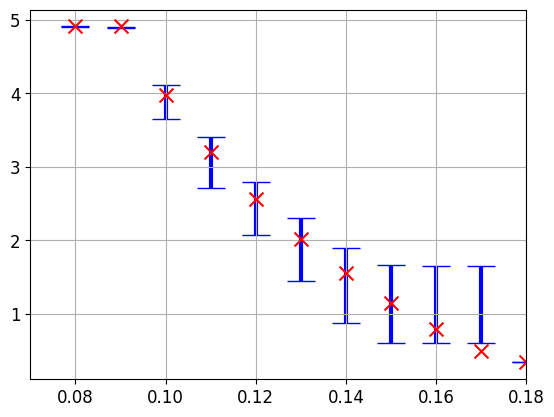

In [ ]:

fontsize = 20
axisfontsize = 12

resilient_reward_rangeub = np.array(PDrewardub)
resilient_reward_rangelb = np.array(PDrewardlb)
center = (resilient_reward_rangeub +resilient_reward_rangelb)/2
width = (resilient_reward_rangeub -resilient_reward_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optreward, label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)

# plt.xscale('log')
# plt.legend()
plt.grid()
plt.savefig('reward.png')

plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
# plt.text(0.05,8.07,'reward vs $\\alpha$', fontsize=16)
plt.xlim(0.07,0.18)
plt.savefig('E2RewardVsAlpha.png', dpi = 300, bbox_inches='tight')
plt.show()

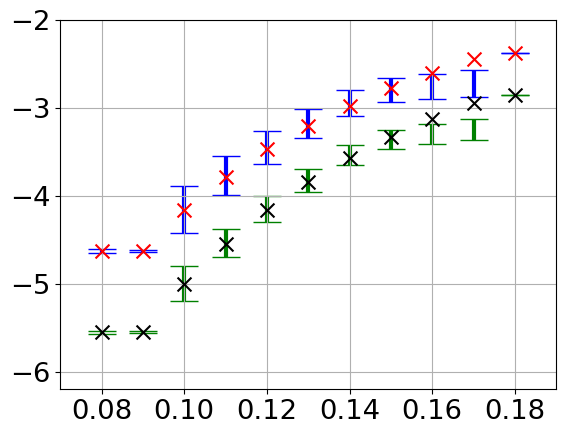

In [ ]:
resilient_xi_rangeub = np.array(PDxi1ub)
resilient_xi_rangelb = np.array(PDxi1lb)
center = (resilient_xi_rangeub +resilient_xi_rangelb)/2
width = (resilient_xi_rangeub -resilient_xi_rangelb)/2
axisfontsize = 19.7
resilient_xi2_rangeub = np.array(PDxi2ub)
resilient_xi2_rangelb = np.array(PDxi2lb)
center2 = (resilient_xi2_rangeub +resilient_xi2_rangelb)/2
width2 = (resilient_xi2_rangeub -resilient_xi2_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='green', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optxi1,label = 'optimistic', marker = 'x', color = 'black', s = 100, zorder = 2)

plt.errorbar(alpha_list, center2, linestyle="None", yerr  = width2, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optxi2,label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)
plt.grid()

plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.ylim(-6.2,-2.0)
plt.xlim(0.07,0.19)


plt.savefig('E2XiVsAlpha.png', dpi = 300, bbox_inches='tight')
plt.show()

## Plot reward, utility and relaxation vs iterations

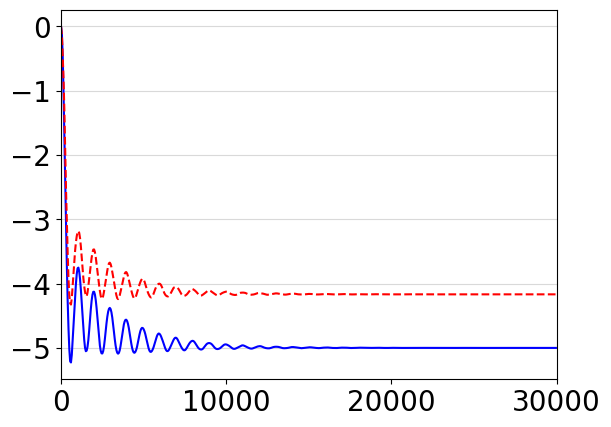

In [33]:
yaxixmax = 30000
fontsize = 28
axisfontsize = 20

num_every = 50
num_grads = np.arange(0, yaxixmax, num_every)
index = 0
plot = 'xi' #xi, utility
method = 'ResOPG-PD' #ResOPG-PD

if plot == 'xi' and method == 'ResOPG-PD':
  plt.plot(num_grads,opt_resilient_xi1[index][:yaxixmax][::num_every], color = 'blue')
  plt.plot(num_grads,opt_resilient_xi2[index][:yaxixmax][::num_every], color = 'red',linestyle= '--')

if plot == 'xi' and method == 'ResPG-PD':
  plt.plot(num_grads,resilient_xi1[index][:yaxixmax][::num_every], color = 'blue')
  plt.plot(num_grads,resilient_xi2[index][:yaxixmax][::num_every],  color = 'red', linestyle = '--')


if plot == 'reward' and method == 'ResOPG-PD':
  plt.plot(num_grads,opt_resilient_reward[index][:yaxixmax][::num_every], color = 'blue')

if plot == 'reward' and method == 'ResPG-PD':
  plt.plot(num_grads,resilient_reward[index][:yaxixmax][::num_every], color = 'blue')


# We move the initial constraints to the left side when recording. So we move them back when plotting
if plot == 'utility' and method == 'ResOPG-PD':
  plt.plot(num_grads,np.array(opt_resilient_utility1[index][:yaxixmax][::num_every])+u_constraint1, color = 'blue')
  plt.plot(num_grads,np.array(opt_resilient_utility2[index][:yaxixmax][::num_every])+u_constraint2, color = 'red')

if plot == 'utility' and method == 'ResPG-PD':
  plt.plot(num_grads,np.array(resilient_utility1[index][:yaxixmax][::num_every])+u_constraint1, color = 'blue')
  plt.plot(num_grads,np.array(resilient_utility2[index][:yaxixmax][::num_every])+u_constraint2, color = 'red')



plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(-20,yaxixmax)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
# plt.yscale('log')
plt.savefig('E2XivsIteropt.png', dpi = 300, bbox_inches='tight')
plt.show()

## Plot reward, utility and relaxation optimality gaps

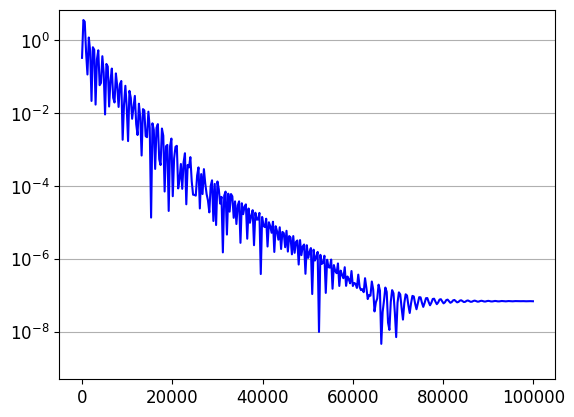

In [ ]:
# Reward
num_every = 300
yaxixmax = 100000
axisfontsize = 12
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.1

method = 'ResOPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_reward[index][:ymax])- optimal_dict[a, a]['reward'])[0][::num_every], color = 'blue')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_reward[index][:ymax])- optimal_dict[a, a]['reward'])[0][::num_every], color = 'blue')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E2RewardErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()

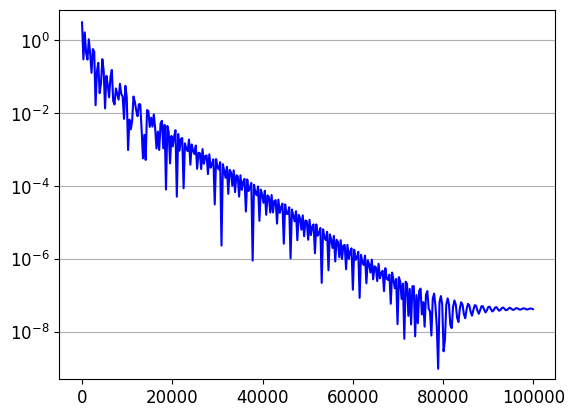

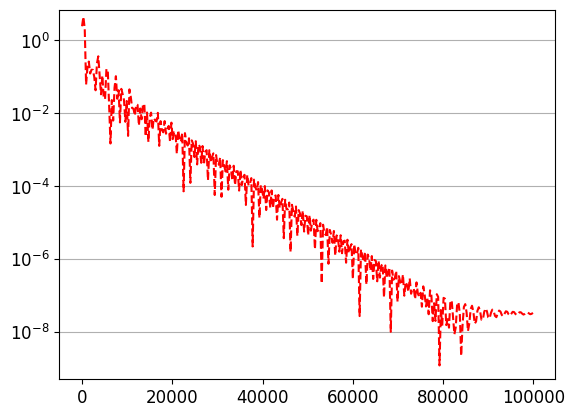

In [20]:
#utility
num_every = 300
yaxixmax = 100000
axisfontsize = 12
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.1

method = 'ResOPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_utility1[index][:ymax])- optimal_dict[a, a]['utility1'])[0][::num_every], color = 'blue')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_utility1[index][:ymax])- optimal_dict[a, a]['utility1'])[0][::num_every], color = 'blue')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E2Utility1ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()



if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_utility2[index][:ymax])- optimal_dict[a, a]['utility2'])[0][::num_every],'--',color = 'red')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_utility2[index][:ymax])- optimal_dict[a, a]['utility2'])[0][::num_every],'--', color = 'red')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E2Utility2ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()

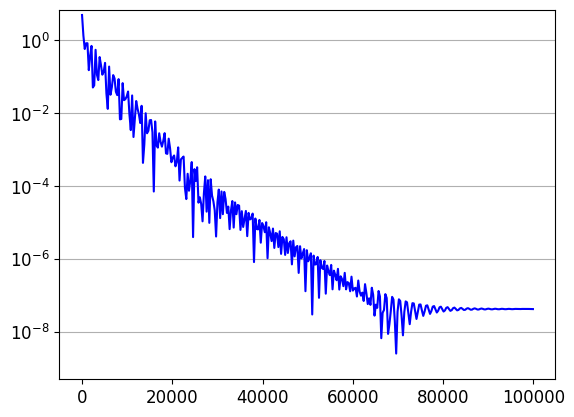

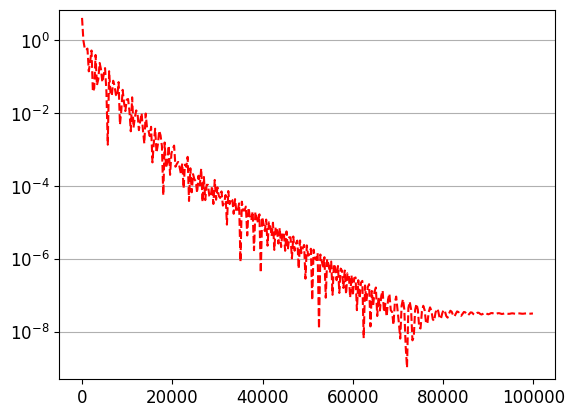

In [ ]:
#relaxation xi
num_every = 300
yaxixmax = 100000
axisfontsize = 12
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.1

method = 'ResOPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_xi1[index][:ymax])- optimal_dict[a, a]['xi1'])[::num_every], color = 'blue')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_xi1[index][:ymax])- optimal_dict[a, a]['xi1'])[::num_every], color = 'blue')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E2Xi1ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()



if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_xi2[index][:ymax])- optimal_dict[a, a]['xi2'])[::num_every],'--',color = 'red')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_xi2[index][:ymax])- optimal_dict[a, a]['xi2'])[::num_every],'--', color = 'red')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E2Xi2ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()